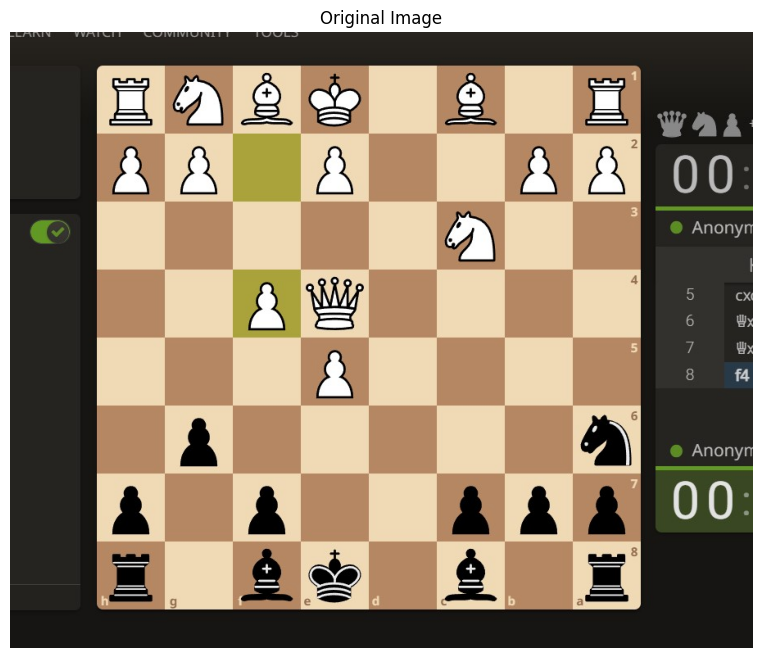

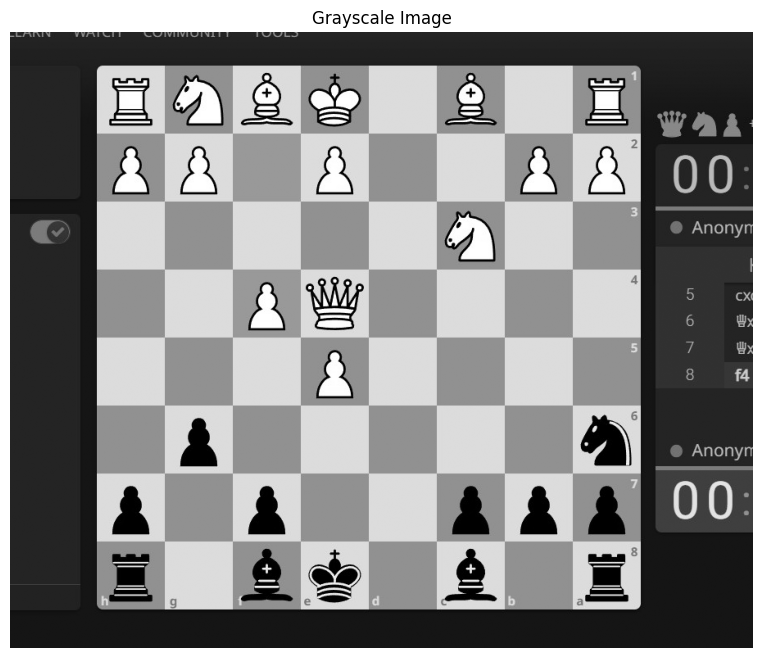

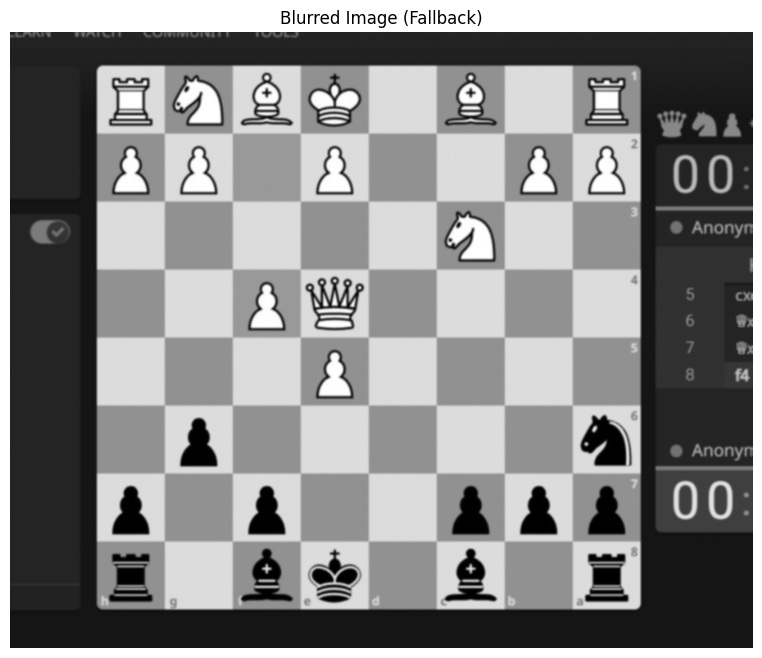

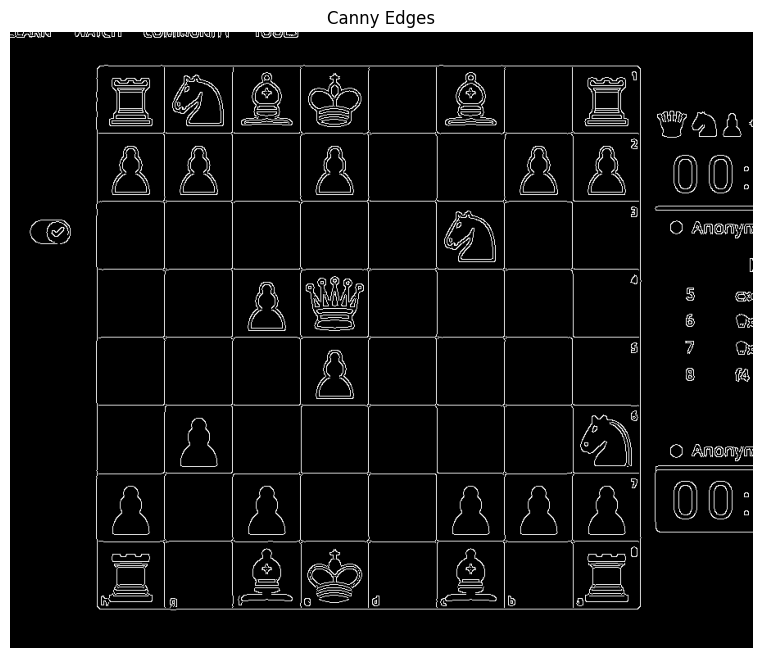

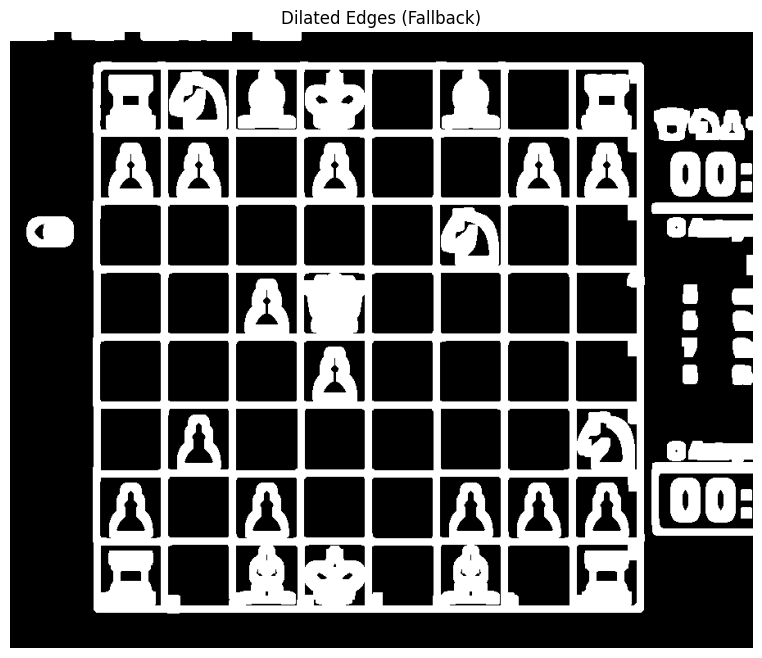

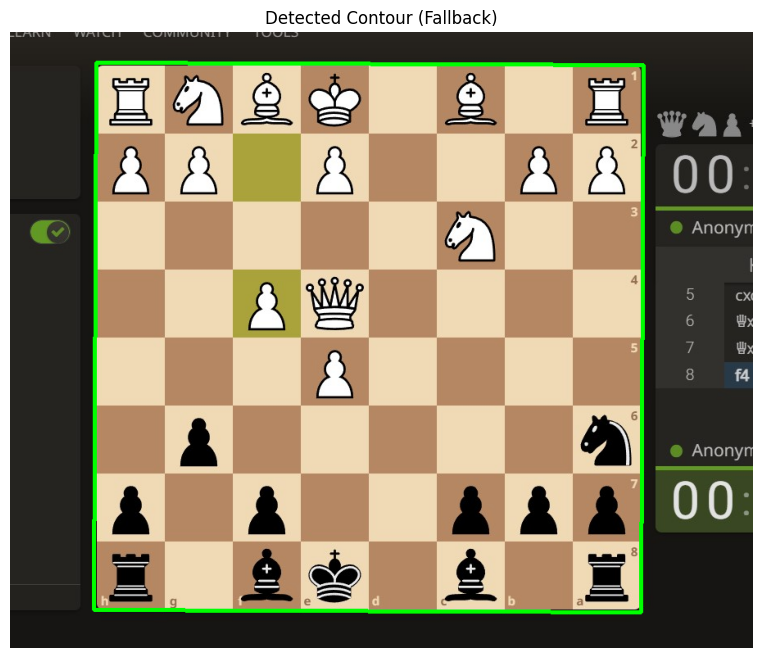

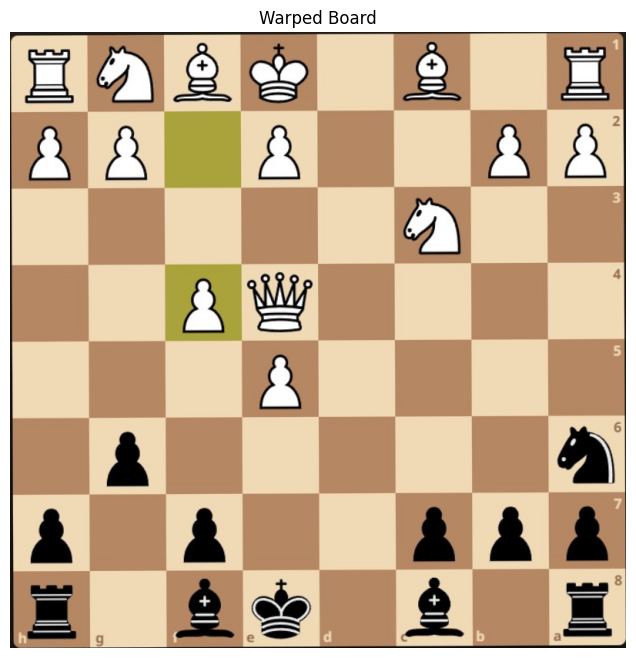

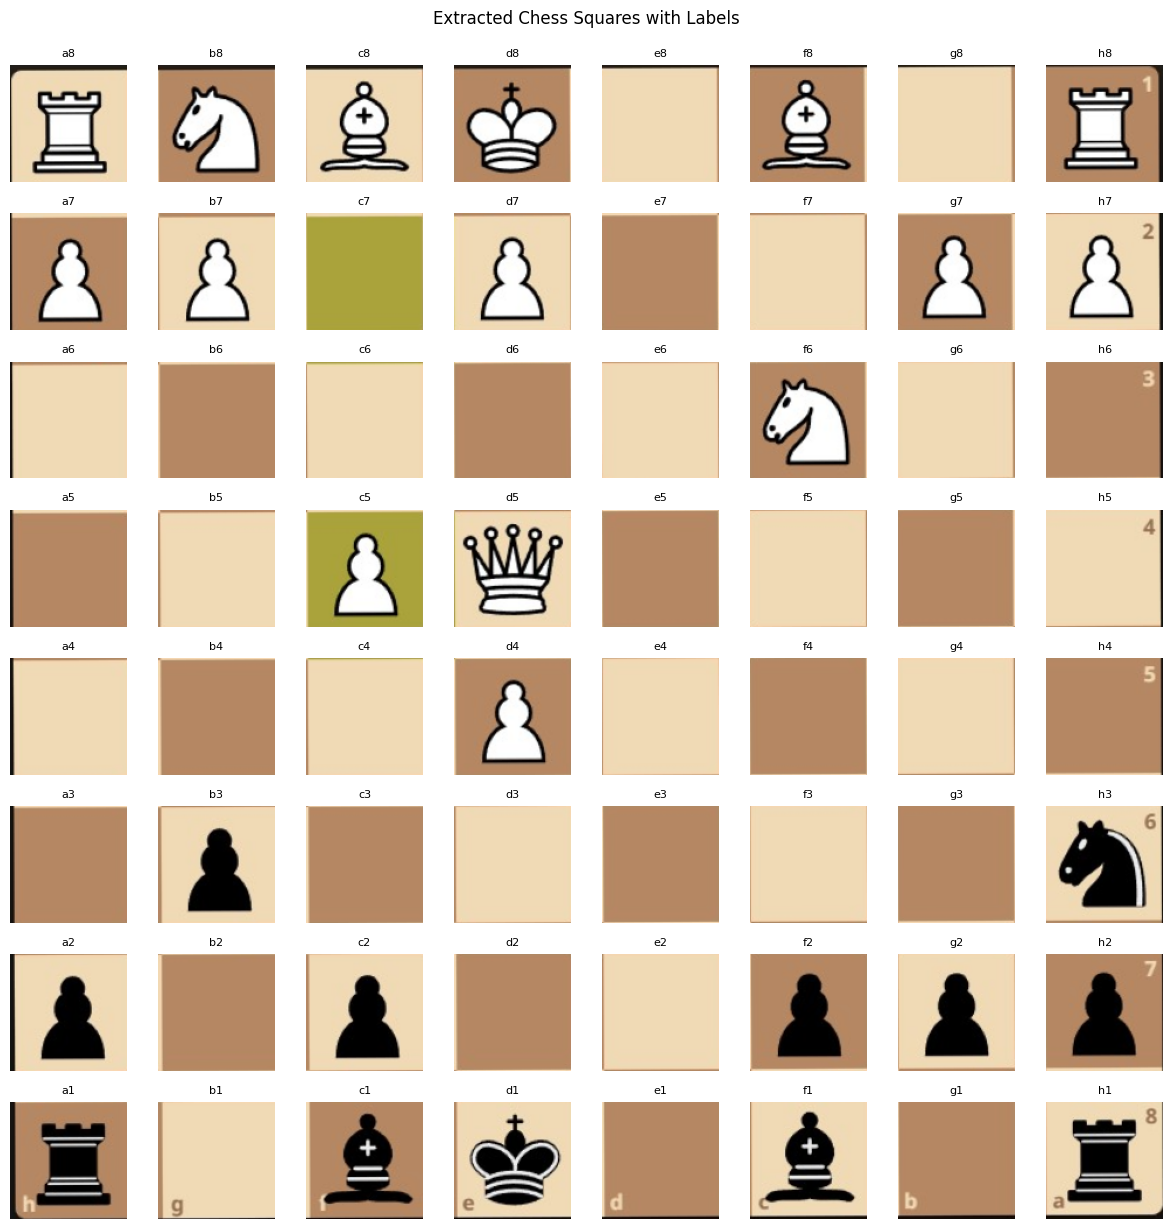

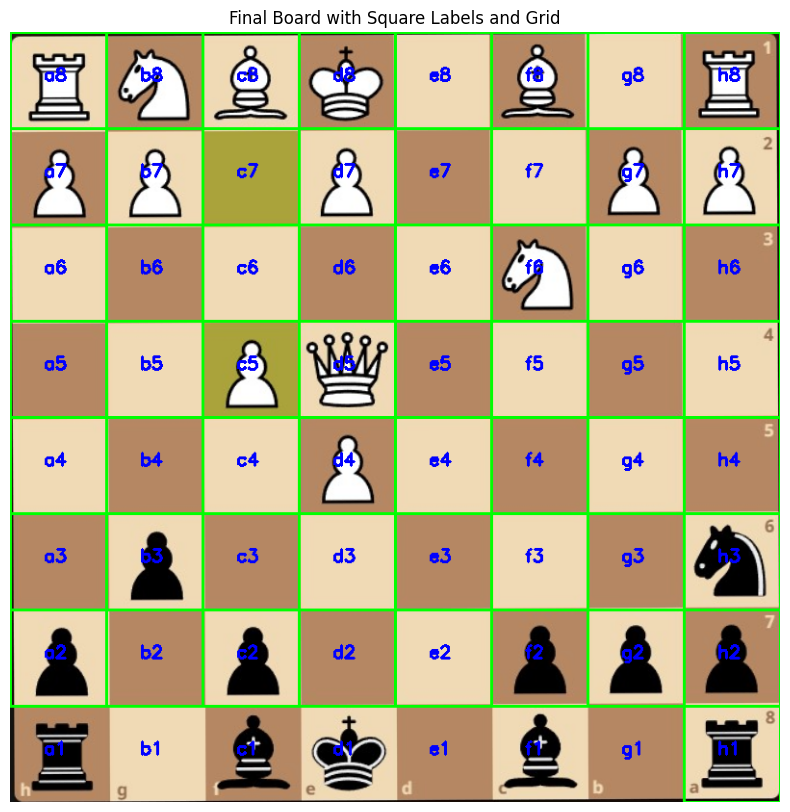

Warped image shape: (800, 800, 3)
a8: R (edges: 1114)
b8: N (edges: 953)
c8: B (edges: 1022)
d8: K (edges: 1045)
e8: Empty (edges: 196)
f8: B (edges: 1011)
g8: Empty (edges: 198)
h8: R (edges: 1151)
a7: P (edges: 679)
b7: P (edges: 681)
c7: Empty (edges: 200)
d7: P (edges: 685)
e7: Empty (edges: 197)
f7: Empty (edges: 197)
g7: P (edges: 679)
h7: P (edges: 740)
a6: Empty (edges: 197)
b6: Empty (edges: 197)
c6: Empty (edges: 197)
d6: Empty (edges: 263)
e6: Empty (edges: 198)
f6: N (edges: 954)
g6: Empty (edges: 228)
h6: Empty (edges: 257)
a5: Empty (edges: 196)
b5: Empty (edges: 197)
c5: P (edges: 684)
d5: Q (edges: 1427)
e5: Empty (edges: 285)
f5: Empty (edges: 261)
g5: Empty (edges: 197)
h5: Empty (edges: 248)
a4: Empty (edges: 196)
b4: Empty (edges: 198)
c4: Empty (edges: 199)
d4: P (edges: 685)
e4: Empty (edges: 284)
f4: Empty (edges: 251)
g4: Empty (edges: 197)
h4: Empty (edges: 255)
a3: Empty (edges: 195)
b3: p (edges: 444)
c3: Empty (edges: 197)
d3: Empty (edges: 254)
e3: Empty (e

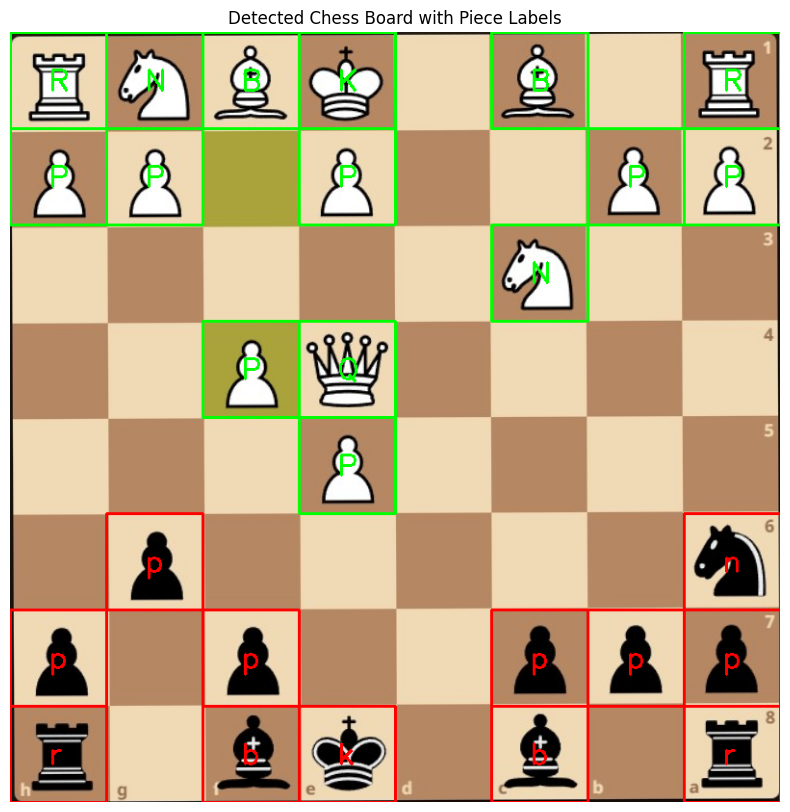

Result saved as 'detected_board.jpg'


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os



def order_corners_manually(points):

    points = points.reshape(4, 2)
    ordered = np.zeros((4, 2), dtype=np.float32)
    sum_xy = points.sum(axis=1)
    diff_xy = np.diff(points, axis=1).flatten()
    ordered[0] = points[np.argmin(sum_xy)]
    ordered[2] = points[np.argmax(sum_xy)]
    ordered[1] = points[np.argmin(diff_xy)]
    ordered[3] = points[np.argmax(diff_xy)]

    return ordered

def detect_and_extract_board(image_path):

    img = cv2.imread(image_path)
    hh = img.shape[0]
    ww = img.shape[1]
    image = img
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(10, 8))
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()


    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    plt.figure(figsize=(10, 8))
    plt.imshow(blur, cmap='gray')
    plt.title("Blurred Image (Fallback)")
    plt.axis('off')
    plt.show()

    edges = cv2.Canny(blur, 50, 150)
    plt.figure(figsize=(10, 8))
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edges")
    plt.axis('off')
    plt.show()

    edges = cv2.dilate(edges, np.ones((5, 5), np.uint8), iterations=2)
    plt.figure(figsize=(10, 8))
    plt.imshow(edges, cmap='gray')
    plt.title("Dilated Edges (Fallback)")
    plt.axis('off')
    plt.show()

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    outer = None
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            outer = order_corners_manually(approx)
            break
    if outer is None:
        raise RuntimeError(" No board corners detected (both methods failed).")


    img_contour = image.copy()
    cv2.drawContours(img_contour, [approx], -1, (0, 255, 0), 3)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB))
    plt.title("Detected Contour (Fallback)")
    plt.axis('off')
    plt.show()


    s = int(800)
    dst = np.array([[0, 0], [s, 0], [s, s], [0, s]], np.float32)
    M = cv2.getPerspectiveTransform(outer, dst)
    warped = cv2.warpPerspective(image, M, (s, s))

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title("Warped Board")
    plt.axis('off')
    plt.show()


    size = s // 8
    files = 'abcdefgh'

    fig, axes = plt.subplots(8, 8, figsize=(12, 12))

    for r in range(8):
        for c in range(8):
            y1, y2 = r * size, (r + 1) * size
            x1, x2 = c * size, (c + 1) * size
            square = warped[y1:y2, x1:x2]
            label = f"{files[c]}{8 - r}"
            axes[r, c].imshow(cv2.cvtColor(square, cv2.COLOR_BGR2RGB))
            axes[r, c].set_title(label, fontsize=8)
            axes[r, c].axis('off')
            cv2.imwrite(f"{label}.png", square)

    plt.tight_layout()
    plt.suptitle("Extracted Chess Squares with Labels", y=1.02)
    plt.show()
    final_display = warped.copy()
    for r in range(8):
        for c in range(8):
            y_center = r * size + size // 2
            x_center = c * size + size // 2
            label = f"{files[c]}{8 - r}"


            cv2.putText(final_display, label,
                       (x_center - 15, y_center),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)


            cv2.rectangle(final_display, (c * size, r * size),
                         ((c + 1) * size, (c + 1) * size), (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(final_display, cv2.COLOR_BGR2RGB))
    plt.title("Final Board with Square Labels and Grid")
    plt.axis('off')
    plt.show()

    
    return warped


def detect_piece(square, template_dir="."):
    gray_square = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
    bilateral_square = cv2.bilateralFilter(gray_square, 9, 75, 75)
    edge_square = cv2.Canny(bilateral_square, 30, 100)
    edge_square = cv2.dilate(edge_square, np.ones((3, 3), np.uint8), iterations=1)
    
    templates = {
        'K.png': 'K',
        'Q.png': 'Q',
        'R.png': 'R',
        'R_special.png': 'R',
        'B.png': 'B',
        'N.png': 'N',
        'P.png': 'P',
        'k_black.png': 'k',
        'q_black.png': 'q',
        'r_black.png': 'r',
        'b_black.png': 'b',
        'n_black.png': 'n',
        'p_black.png': 'p'
    }

    best_match = None
    best_score = 0
    default_threshold = 0.25

    for template_file, piece_code in templates.items():
        template_path = os.path.join(template_dir, template_file)

        if not os.path.exists(template_path):
            print(f"Warning: Template {template_path} not found")
            continue

        template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
        if template is None:
            continue

        if template.shape != gray_square.shape:
            template = cv2.resize(template, (gray_square.shape[1], gray_square.shape[0]))

        bilateral_template = cv2.bilateralFilter(template, 9, 75, 75)
        edge_template = cv2.Canny(bilateral_template, 30, 100)
        edge_template = cv2.dilate(edge_template, np.ones((3, 3), np.uint8), iterations=1)

        result_bilateral = cv2.matchTemplate(bilateral_square, bilateral_template, cv2.TM_CCOEFF_NORMED)
        _, max_val_bilateral, _, _ = cv2.minMaxLoc(result_bilateral)

        result_edge = cv2.matchTemplate(edge_square, edge_template, cv2.TM_CCOEFF_NORMED)
        _, max_val_edge, _, _ = cv2.minMaxLoc(result_edge)

        result_gray = cv2.matchTemplate(gray_square, template, cv2.TM_CCOEFF_NORMED)
        _, max_val_gray, _, _ = cv2.minMaxLoc(result_gray)

        combined_score = 0.3 * max_val_gray + 0.3 * max_val_bilateral + 0.4 * max_val_edge

        if template_file == 'R_special.png':
            current_threshold = 0.6
        elif template_file == 'P.png':
            current_threshold = 0.12
        else:
            current_threshold = default_threshold

        if combined_score > best_score and combined_score > current_threshold:
            best_score = combined_score
            best_match = piece_code

    return best_match

def visualize_board(board_state, warped_image):
    visualized = warped_image.copy()
    size = warped_image.shape[0] // 8

    WHITE_PIECE_COLOR = (0, 255, 0)
    BLACK_PIECE_COLOR = (0, 0, 255)

    for r in range(8):
        for c in range(8):
            piece = board_state[r][c]
            if piece:
                x_center = c * size + size // 2
                y_center = r * size + size // 2


                color = WHITE_PIECE_COLOR if piece.isupper() else BLACK_PIECE_COLOR

                cv2.putText(visualized, piece, (x_center - 10, y_center + 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)


                cv2.rectangle(visualized,
                            (c * size, r * size),
                            ((c + 1) * size, (r + 1) * size),
                            color, 2)

    return visualized



if __name__ == "__main__":
    image_path = "chess294.jpg"
    try:
        warped = detect_and_extract_board(image_path)
        size = 100
        print(f"Warped image shape: {warped.shape}")

        
        board_state = [[None for _ in range(8)] for _ in range(8)]
        files = "abcdefgh"

        for r in range(8):
            for c in range(8):
                y1, y2 = r * size, (r + 1) * size
                x1, x2 = c * size, (c + 1) * size
                square = warped[y1:y2, x1:x2]

                
                gray_square = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
                edges = cv2.Canny(gray_square, 50, 150)
                edge_count = np.count_nonzero(edges)

                piece = detect_piece(square)

                board_state[r][c] = piece
                label = f"{files[c]}{8 - r}"

                if piece:
                    print(f"{label}: {piece} (edges: {edge_count})")
                else:
                    print(f"{label}: Empty (edges: {edge_count})")

       
        visualized_board = visualize_board(board_state, warped)

        
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(visualized_board, cv2.COLOR_BGR2RGB))
        plt.title("Detected Chess Board with Piece Labels")
        plt.axis('off')
        plt.show()


        
        cv2.imwrite("detected_board.jpg", visualized_board)
        print("Result saved as 'detected_board.jpg'")

    except Exception as e:
        print(f" Error: {e}")